In [1]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

In [2]:
import rasterio
from rasterio.windows import Window

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seeds();

In [5]:
DATA_PATH = '../input/hubmap-kidney-segmentation'
EPOCHES = 9
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [7]:
class HubDataset(D.Dataset):

    def __init__(self, root_dir, transform,
                 window=256, overlap=64, threshold = 500):
        self.path = pathlib.Path(root_dir)
        self.overlap = overlap
        self.window = window
        self.transform = transform
        self.csv = pd.read_csv((self.path / 'train.csv').as_posix(),
                               index_col=[0])
        self.threshold = threshold
        self.build_slices()
        self.len = len(self.slices)
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        
        
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        for i, filename in enumerate(self.csv.index.values):
            filepath = (self.path /'train'/(filename+'.tiff')).as_posix()
            self.files.append(filepath)
            with rasterio.open(filepath, transform = identity) as dataset:
                self.masks.append(rle_decode(
                    self.csv.loc[filename, 'encoding'], dataset.shape))
                slices = make_grid(dataset.shape, window=self.window,
                                   min_overlap=self.overlap)
                for slc in slices:
                    x1,x2,y1,y2 = slc
                    if dataset.read(1, window=Window.from_slices((x1,x2),(y1,y2))).sum() == 0:
                        continue
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold or random.random() < 0.2:
                        self.slices.append([i,x1,x2,y1,y2])
                        
                        
                        
    def __getitem__(self, index):
        
        idx = self.slices[index][0]
        filename = self.files[idx]
        x1,x2,y1,y2 = self.slices[index][1:] 
        with rasterio.open(filename, transform = identity) as dataset:
            channels = [1,2,3] if dataset.count == 3 else [1,1,1]
            image = dataset.read(channels,window=Window.from_slices((x1,x2),(y1,y2)))    
            image = np.moveaxis(image, 0, -1)
            
        mask = self.masks[idx][x1:x2,y1:y2]
        
        augments = self.transform(image=image, mask=mask)
        return self.as_tensor(augments['image']), augments['mask'][None]
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [8]:
WINDOW=1024
MIN_OVERLAP=32
NEW_SIZE=256

trfm = A.Compose([
    A.Resize(NEW_SIZE,NEW_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter (brightness=0.07, contrast=0.07,
                   saturation=0.1, hue=0.1, always_apply=False, p=0.3)
])

ds = HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

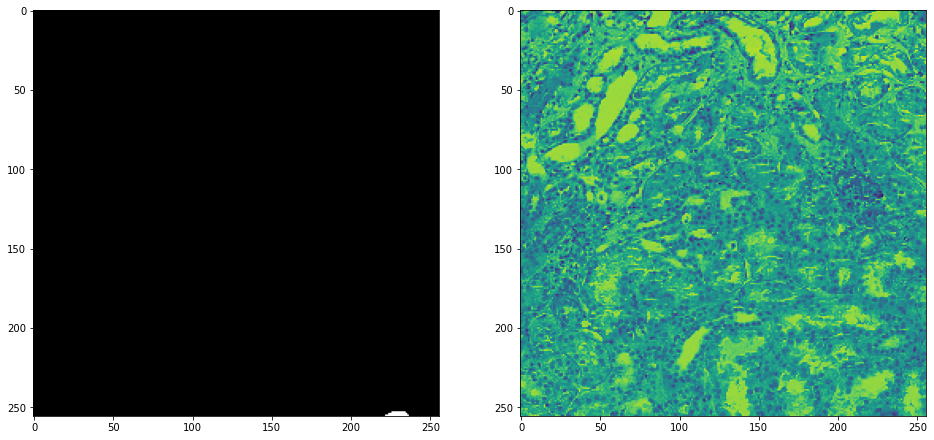

In [9]:
image, mask = ds[12]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);

In [10]:
valid_idx, train_idx = [], []
for i in range(len(ds)):
    if ds.slices[i][0] == 7:
        valid_idx.append(i)
    else:
        train_idx.append(i)

In [11]:
train_ds = D.Subset(ds, train_idx)
valid_ds = D.Subset(ds, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [12]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

In [13]:
@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [15]:
model = get_model()

model.to(DEVICE);

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

In [16]:
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'

In [17]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc

In [18]:
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice

print(header)

for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in loader:
        
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []


        Train | Valid
Epoch |  Loss |  Loss | Time, m

     1│  0.283│  0.190│ 15.58
     2│  0.171│  0.145│ 14.46
     3│  0.140│  0.128│ 14.48
     4│  0.126│  0.120│ 13.89
     5│  0.117│  0.113│ 13.98
     6│  0.112│  0.112│ 14.05
     7│  0.109│  0.108│ 14.21
     8│  0.107│  0.113│ 13.88
     9│  0.100│  0.094│ 13.87


In [20]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(NEW_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

model.eval()

p = pathlib.Path(DATA_PATH)

subm = {}

for i, filename in enumerate(p.glob('test/*.tiff')):
    dataset = rasterio.open(filename.as_posix(), transform = identity)
    slices = make_grid(dataset.shape, window=WINDOW, min_overlap=MIN_OVERLAP)
    preds = np.zeros(dataset.shape, dtype=np.uint8)
    for (x1,x2,y1,y2) in slices:
        channels = [1,2,3] if dataset.count == 3 else [1,1,1]
        image = dataset.read(channels,
                    window=Window.from_slices((x1,x2),(y1,y2)))
        image = np.moveaxis(image, 0, -1)
        image = trfm(image)
        with torch.no_grad():
            score = model(image.to(DEVICE)[None])['out'][0][0]
            score = score.cpu().numpy()
            score = cv2.resize(score, (WINDOW, WINDOW))
            preds[x1:x2,y1:y2] = (score > 0).astype(np.uint8)
            
    subm[i] = {'id':filename.stem, 'predicted': rle_encode_less_memory(preds)}
    del preds
    gc.collect();